Este programa toma la serie a precios corrientes y le hace un EDA (exploratory data analysis)
Vemos algunas medidas estadísticas y observamos estacionalidad.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns


Cargo la serie Ventas en millones de pesos

In [30]:
serie = pd.read_csv('serieScorr.csv', encoding= 'unicode_escape', delimiter=',') 
serie['indice_tiempo'] = pd.to_datetime(serie['indice_tiempo'])

Veo si esta bien cargada

In [3]:
print(serie.head())  # muestra las primeras filas de la serie de tiempo
print(serie.tail())  # muestra las últimas filas de la serie de tiempo
print(serie.describe())  # muestra estadísticas básicas de la serie de tiempo
print(serie.info())  # muestra información sobre la serie de tiempo


  indice_tiempo  ventas_precios_corrientes
0    1996-01-01                     998.77
1    1996-02-01                    1022.71
2    1996-03-01                    1149.27
3    1996-04-01                    1077.44
4    1996-05-01                    1050.08
    indice_tiempo  ventas_precios_corrientes
320    2022-09-01              232153.157225
321    2022-10-01              265665.688890
322    2022-11-01              284825.273120
323    2022-12-01              359730.267987
324    2023-01-01              316671.875716
       ventas_precios_corrientes
count                 325.000000
mean                25840.926444
std                 51573.856400
min                   998.770000
25%                  1395.540000
50%                  4480.560000
75%                 23497.870000
max                359730.267987
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------    

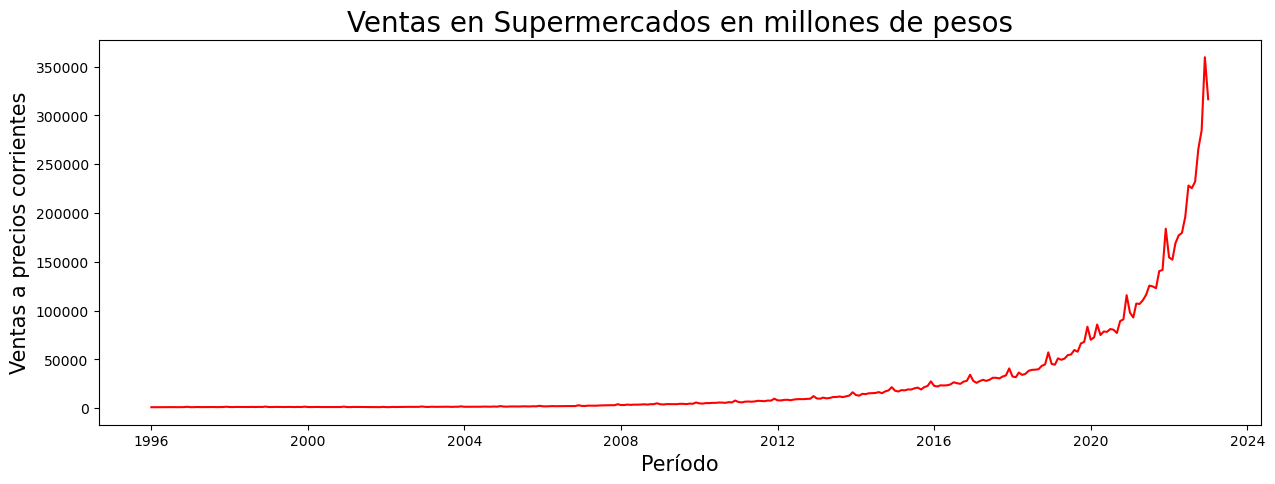

In [31]:
plt.figure(figsize=(15,5))
sns.lineplot(x='indice_tiempo', y='ventas_precios_corrientes', data=serie, color='r')
plt.ylabel('Ventas a precios corrientes', fontsize=15)
plt.xlabel('Período', fontsize=15)
plt.title('Ventas en Supermercados en millones de pesos', fontsize=20);

<Axes: >

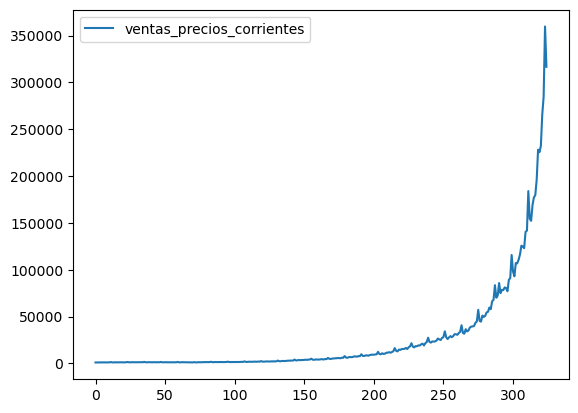

In [5]:
serie.plot()

Analizo estacionalidad

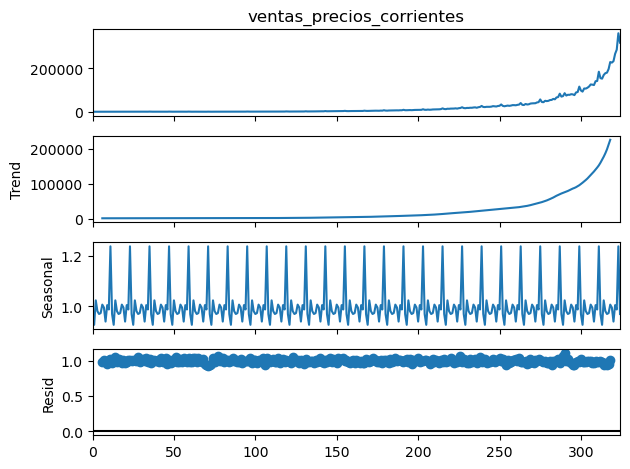

In [32]:

result = seasonal_decompose(serie['ventas_precios_corrientes'], model='multiplicative', period=12)
result.plot()
plt.show()

La transformo en estacionaria

In [33]:
import numpy as np
ventas=serie['ventas_precios_corrientes']
ventas = np.log(ventas) # don't forget to transform the data back when making real predictions
type(serie)
serie['lnventas']=ventas


In [34]:
serie

,indice_tiempo,ventas_precios_corrientes,lnventas
0,1996-01-01,998.770000,6.906525
1,1996-02-01,1022.710000,6.930211
2,1996-03-01,1149.270000,7.046882
3,1996-04-01,1077.440000,6.982343
4,1996-05-01,1050.080000,6.956622
...,...,...,...
320,2022-09-01,232153.157225,12.355153
321,2022-10-01,265665.688890,12.489994
322,2022-11-01,284825.273120,12.559631
323,2022-12-01,359730.267987,12.793110


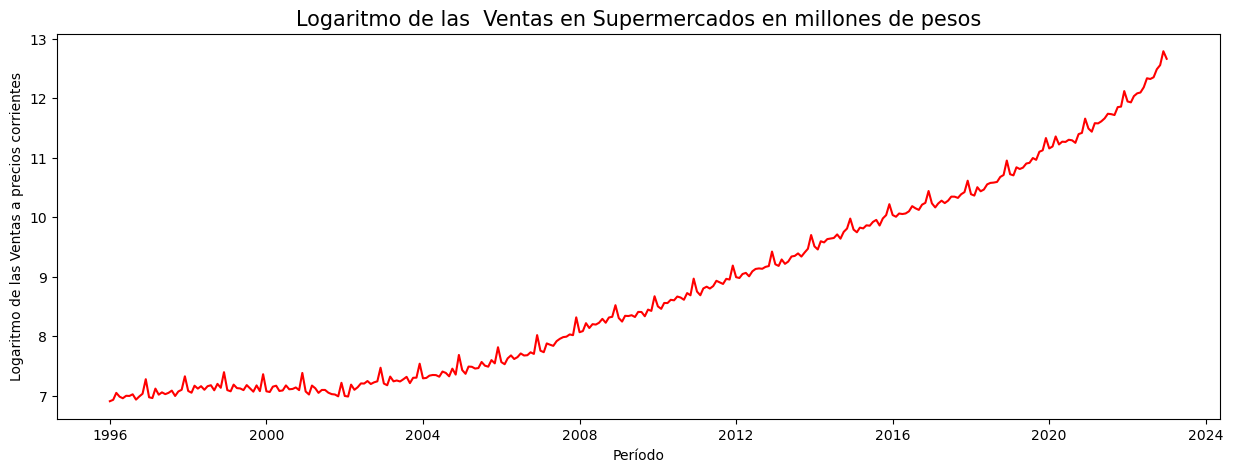

In [36]:
plt.figure(figsize=(15,5))
sns.lineplot(x='indice_tiempo', y='lnventas', data=serie, color='r')
plt.ylabel('Logaritmo de las Ventas a precios corrientes', fontsize=10)
plt.xlabel('Período')
plt.title('Logaritmo de las  Ventas en Supermercados en millones de pesos', fontsize=15);

Calculo ACF y PACF para ver si hay que diferenciar, si el ACF cae despacio hay que diferenciar

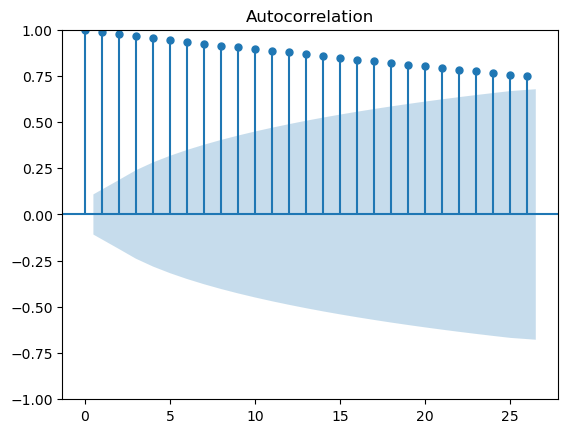

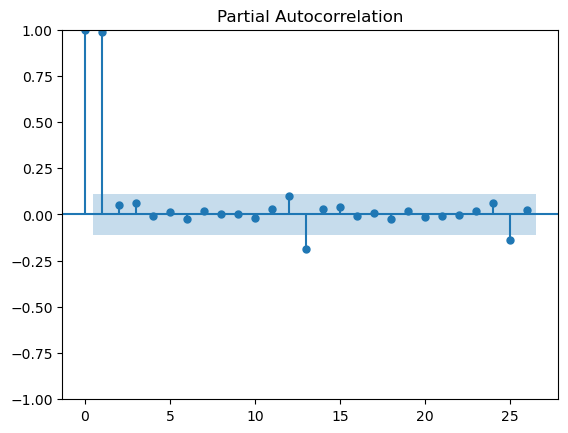

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(ventas)
pacf_original = plot_pacf(ventas)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

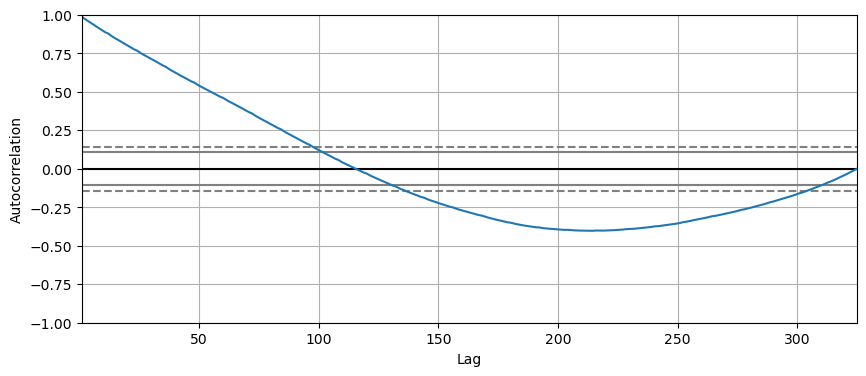

In [46]:
from pandas.plotting import autocorrelation_plot
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':100})
autocorrelation_plot(ventas.tolist())

Testeo adft para ver si hay que diferenciar

In [40]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(ventas)
print(f'p-value: {adf_test[1]}')

p-value: 0.9990656191762264


Diferencio

In [41]:
ventas_diff = ventas.diff().dropna()
adf_test = adfuller(ventas_diff)
print(f'p-value: {adf_test[1]}')


p-value: 0.9257355279169514


Vuelvo a diferenciar

In [42]:
ventas_diff2= ventas_diff.diff().dropna()
adf_test = adfuller(ventas_diff2)
print(f'p-value: {adf_test[1]}')

p-value: 2.248622302867003e-14


Grafico

<Axes: >

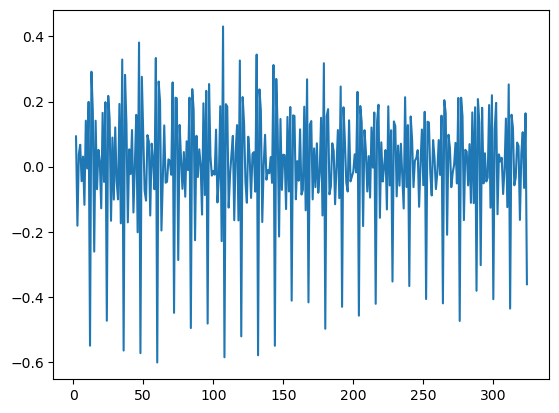

In [43]:
ventas_diff2.plot()

In [51]:
serie['indice_tiempo'] = pd.to_datetime(serie['indice_tiempo'])
serie['month'] = serie['indice_tiempo'].dt.month
serie['year'] = serie['indice_tiempo'].dt.year
mesdiff2 = pd.Series(serie['month'][2:], name='mes')
yeardiff2=pd.Series(serie['year'][2:], name='anio')
D=pd.concat([serie['indice_tiempo'],mesdiff2,yeardiff2,ventas_diff2],axis=1)
D

,indice_tiempo,mes,anio,ventas_precios_corrientes
0,1996-01-01,NaN,NaN,NaN
1,1996-02-01,NaN,NaN,NaN
2,1996-03-01,3.0,1996.0,0.092984
3,1996-04-01,4.0,1996.0,-0.181210
4,1996-05-01,5.0,1996.0,0.038818
...,...,...,...,...
320,2022-09-01,9.0,2022.0,0.040975
321,2022-10-01,10.0,2022.0,0.105800
322,2022-11-01,11.0,2022.0,-0.065204
323,2022-12-01,12.0,2022.0,0.163841


Text(0.5, 1.0, 'Doble diferenciación de lasVentas en Supermercados en millones de pesos')

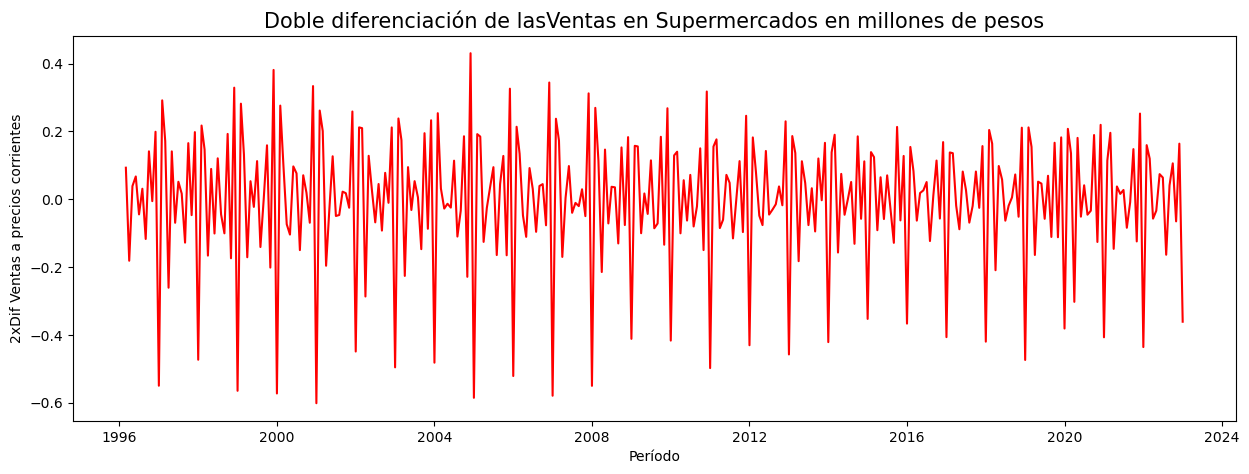

In [52]:
plt.figure(figsize=(15,5))
sns.lineplot(x='indice_tiempo', y='ventas_precios_corrientes', data=D, color='r')
plt.ylabel('2xDif Ventas a precios corrientes', fontsize=10)
plt.xlabel('Período')
plt.title('Doble diferenciación de lasVentas en Supermercados en millones de pesos', fontsize=15)

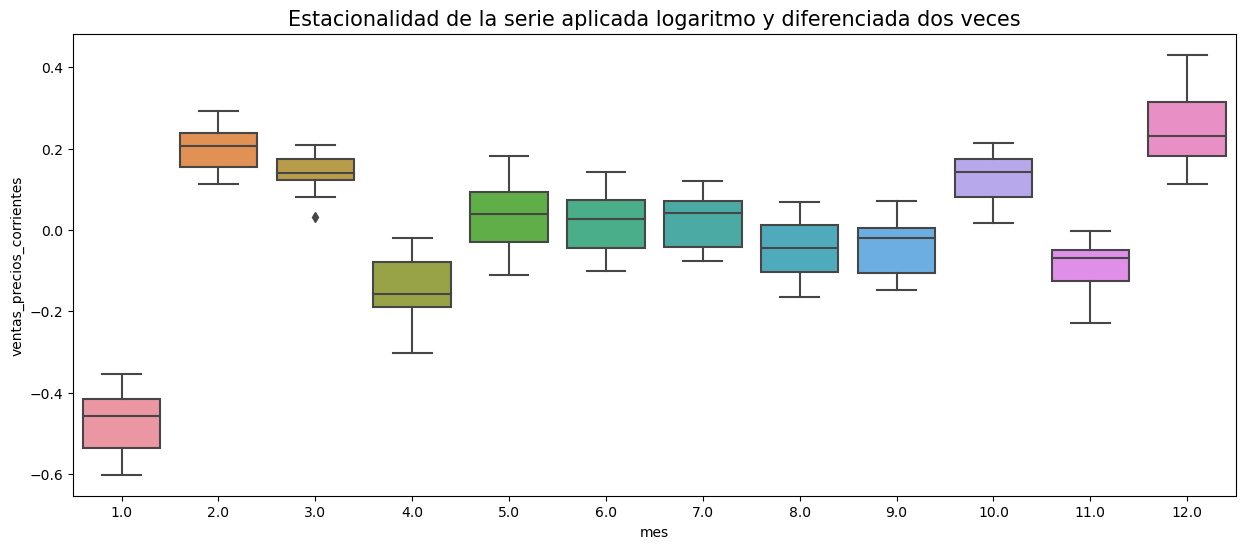

In [54]:
plt.figure(figsize=(15,6))
sns.boxplot(x="mes", y="ventas_precios_corrientes", data=D).set_title("Estacionalidad de la serie aplicada logaritmo y diferenciada dos veces", fontsize=15)
plt.show()